# Лабораторная работа №4. Латентное размещение Дирихле

В рамках данной лабораторной работы предстоит реализовать алгоритм латентного размещения Дирихле (LDA) и сравнить его с эталонной реализацией из библиотеки `scikit-learn`.

## Задание

1. Выбрать текстовый датасет для анализа, например, на [kaggle](https://www.kaggle.com/datasets).
2. Реализовать алгоритм латентного размещения Дирихле.
3. Обучить модель на выбранном датасете.
4. Оценить качество модели с использованием метрик когерентности тем.
5. Замерить время обучения модели.
6. Сравнить результаты с эталонной реализацией из библиотеки [scikit-learn](https://scikit-learn.org/stable/):
   * когерентность тем;
   * время обучения.
7. Подготовить отчет, включающий:
   * описание алгоритма латентного размещения Дирихле;
   * описание датасета;
   * результаты экспериментов;
   * сравнение с эталонной реализацией;
   * выводы.

# 1. Выбрать текстовый датасет для анализа, например, на [kaggle](https://www.kaggle.com/datasets)
### В качестве датасета был выбран набор данных для тематического моделирования

### Ссылка:

https://www.kaggle.com/datasets/nandaprasetia/csv-200-20newsgroups

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nandaprasetia/csv-200-20newsgroups")

print("Path to dataset files:", path)

c:\Users\klimm\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\klimm\.cache\kagglehub\datasets\nandaprasetia\csv-200-20newsgroups\versions\1


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('train200.csv')
df.shape

(7889, 3)

In [3]:
df.isnull().sum()

documents      0
labels         0
label_names    0
dtype: int64

In [4]:
df.columns

Index(['documents', 'labels', 'label_names'], dtype='object')

In [5]:
documents_col = 'documents'
labels_col = 'labels'

## Анализ категорий

Общее количество документов: 7889
Количество уникальных категорий: 20
Распределение по категориям:
  0:  332 документов - alt.atheism
  1:  464 документов - comp.graphics
  2:  453 документов - comp.os.ms-windows.misc
  3:  468 документов - comp.sys.ibm.pc.hardware
  4:  454 документов - comp.sys.mac.hardware
  5:  457 документов - comp.windows.x
  6:  468 документов - misc.forsale
  7:  441 документов - rec.autos
  8:  433 документов - rec.motorcycles
  9:  416 документов - rec.sport.baseball
  10:  403 документов - rec.sport.hockey
  11:  363 документов - sci.crypt
  12:  462 документов - sci.electronics
  13:  407 документов - sci.med
  14:  417 документов - sci.space
  15:  315 документов - soc.religion.christian
  16:  348 документов - talk.politics.guns
  17:  290 документов - talk.politics.mideast
  18:  281 документов - talk.politics.misc
  19:  217 документов - talk.religion.misc


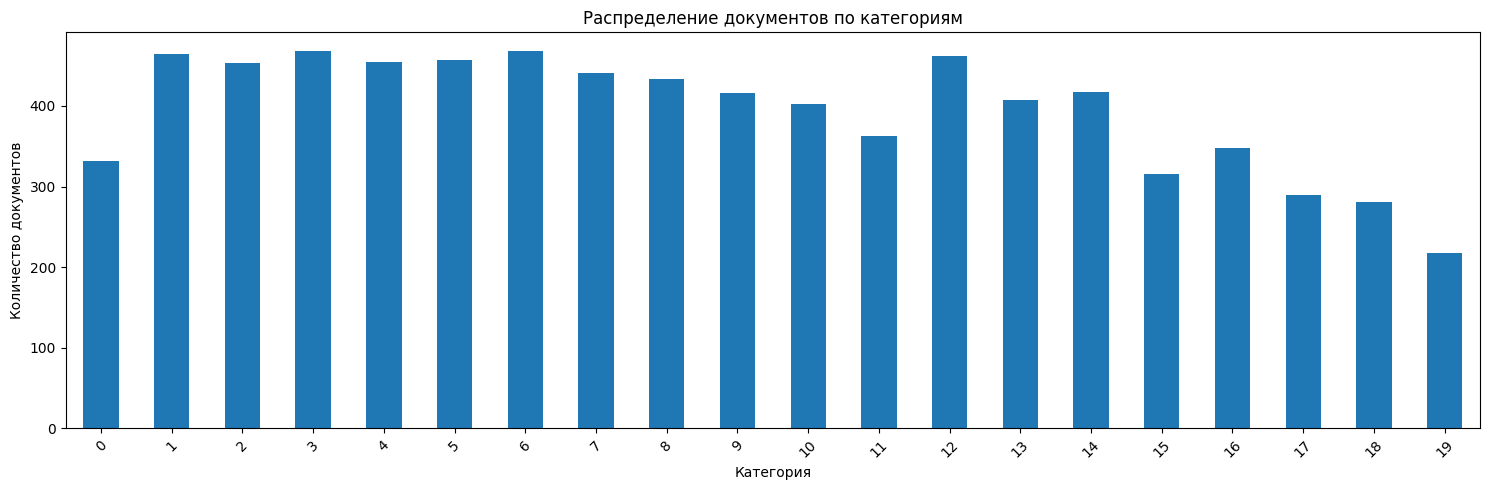


Сбалансированность категорий:
  Минимум документов в категории: 217
  Максимум документов в категории: 468
  Соотношение макс/мин: 2.2


In [6]:
if labels_col in df.columns:
    label_counts = df[labels_col].value_counts().sort_index()
    print(f"Общее количество документов: {len(df)}")
    print(f"Количество уникальных категорий: {df[labels_col].nunique()}")
    
    print("Распределение по категориям:")
    for label, count in label_counts.items():
        label_name = df[df[labels_col] == label]['label_names'].iloc[0]
        print(f"  {label}: {count:4d} документов - {label_name}")
    
    plt.figure(figsize=(15, 5))
    label_counts.plot(kind='bar')
    plt.title('Распределение документов по категориям')
    plt.xlabel('Категория')
    plt.ylabel('Количество документов')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Проверка сбалансированности
    min_docs = label_counts.min()
    max_docs = label_counts.max()
    print(f"\nСбалансированность категорий:")
    print(f"  Минимум документов в категории: {min_docs}")
    print(f"  Максимум документов в категории: {max_docs}")
    print(f"  Соотношение макс/мин: {max_docs/min_docs:.1f}")

Датасет неплохо сбалансирован, соотношение приемлимое

In [7]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


In [9]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\klimm\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\klimm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\klimm\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\klimm\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [8]:
def preprocess_text(text):
    """Предобработка одного документа для LDA"""
    if pd.isna(text):
        return ""
    
    # Приведение к нижнему регистру
    text = text.lower()
    
    # Удаление URL, email, специальных символов
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Токенизация
    tokens = word_tokenize(text)
    
    # Удаление стоп-слов
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Удаление коротких слов
    tokens = [token for token in tokens if len(token) >= 3]
    
    # Лемматизация
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return ' '.join(tokens)

# Применяем предобработку
df['processed_text'] = df[documents_col].apply(preprocess_text)

# Удаляем пустые документы
df_clean = df[df['processed_text'].str.len() > 10].copy()
print(f"Документов до предобработки: {len(df)}")
print(f"Документов после предобработки: {len(df_clean)}")

# Показываем пример
print("\nПример предобработки:")
print("Исходный текст:")
print(df[documents_col].iloc[0][:200], "...")
print("\nОбработанный текст:")
print(df_clean['processed_text'].iloc[0][:200], "...")

Документов до предобработки: 7889
Документов после предобработки: 7888

Пример предобработки:
Исходный текст:
I was wondering if anyone out there could enlighten me on this car I saw the other day. It was a 2door sports car, looked to be from the late 60s early 70s. It was called a Bricklin. The doors were re ...

Обработанный текст:
wondering anyone could enlighten car saw day door sport car looked late early called bricklin door really small addition front bumper separate rest body know anyone tellme model name engine spec year  ...


In [9]:
from collections import defaultdict

In [10]:
def create_dictionary_and_corpus(documents):
    """Создает словарь и корпус для LDA"""
    
    # Токенизация документов
    tokenized_docs = [doc.split() for doc in documents]
    print(f"Всего документов: {len(tokenized_docs)}")
    
    # Подсчет частоты слов
    word_freq = defaultdict(int)
    doc_freq = defaultdict(int)
    
    for doc in tokenized_docs:
        unique_words = set(doc)
        for word in doc:
            word_freq[word] += 1
        for word in unique_words:
            doc_freq[word] += 1
    
    print(f"Уникальных слов до фильтрации: {len(word_freq)}")
    
    # Фильтрация слов
    min_freq = 5        # слово должно встречаться минимум 5 раз
    max_doc_ratio = 0.5 # слово не должно быть в >50% документов
    n_docs = len(tokenized_docs)
    
    # Создание словаря
    word_to_id = {}
    id_to_word = {}
    current_id = 0
    
    for word, freq in word_freq.items():
        doc_ratio = doc_freq[word] / n_docs
        if freq >= min_freq and doc_ratio <= max_doc_ratio:
            word_to_id[word] = current_id
            id_to_word[current_id] = word
            current_id += 1
    
    print(f"Слов в словаре после фильтрации: {len(word_to_id)}")
    
    # Создание корпуса (bag-of-words)
    corpus = []
    for doc in tokenized_docs:
        doc_bow = [0] * len(word_to_id)
        for word in doc:
            if word in word_to_id:
                doc_bow[word_to_id[word]] += 1
        # Пропускаем документы без слов из словаря
        if sum(doc_bow) > 0:
            corpus.append(doc_bow)
    
    print(f"Документов в корпусе: {len(corpus)}")
    return word_to_id, id_to_word, corpus

# Создаем словарь и корпус
documents = df_clean['processed_text'].tolist()
word_to_id, id_to_word, corpus = create_dictionary_and_corpus(documents)

# Показываем примеры
print("\nПримеры словаря:")
sample_words = list(word_to_id.items())[:10]
for word, word_id in sample_words:
    print(f"{word_id:3d}: {word}")

print("\nПример документа (BOW):")
print("Первые 20 слов документа:")
doc_example = corpus[0][:20]
for i, count in enumerate(doc_example):
    if count > 0:
        print(f"{id_to_word[i]}: {count}")

Всего документов: 7888
Уникальных слов до фильтрации: 32354
Слов в словаре после фильтрации: 6995
Документов в корпусе: 7888

Примеры словаря:
  0: wondering
  1: anyone
  2: could
  3: enlighten
  4: car
  5: saw
  6: day
  7: door
  8: sport
  9: looked

Пример документа (BOW):
Первые 20 слов документа:
wondering: 1
anyone: 2
could: 1
enlighten: 1
car: 4
saw: 1
day: 1
door: 2
sport: 1
looked: 1
late: 1
early: 1
called: 1
really: 1
small: 1
addition: 1
front: 1
bumper: 1
separate: 1
rest: 1


# 2. Реализовать алгоритм латентного размещения Дирихле

In [11]:
import time
import numpy as np

In [13]:
class CustomLDA:
    """
    Собственная реализация LDA с сэмплированием Гиббса
    """
    def __init__(self, n_topics, alpha=0.1, beta=0.01, n_iterations=100, random_state=42):
        self.n_topics = n_topics
        self.alpha = alpha
        self.beta = beta
        self.n_iterations = n_iterations
        self.random_state = random_state
        np.random.seed(random_state)
        
    def fit(self, corpus, vocabulary):
        """Обучение"""
        self.vocabulary = vocabulary
        self.V = len(vocabulary)
        self.D = len(corpus)
        
        print(f"Документов: {self.D}")
        print(f"Словарь: {self.V} слов")
        print(f"Тем: {self.n_topics}")
        
        # Векторизованная инициализация
        self._vectorized_initialize(corpus)
        
        # Предвычисляем константы для ускорения
        self.alpha_sum = self.n_topics * self.alpha
        self.beta_sum = self.V * self.beta
        
        # Сэмплирование
        for iteration in range(self.n_iterations):
            if iteration % 20 == 0:
                print(f"Итерация {iteration}/{self.n_iterations}")
            self._vectorized_gibbs_sampling()

        # Векторизованные финальные распределения
        self._vectorized_compute_distributions()
        
    def _vectorized_initialize(self, corpus):
        """Инициализация"""
        
        # Преобразуем в плоские массивы
        self.words = []
        self.docs = []
        self.topics = []
        
        total_words = 0
        for doc_id, doc_bow in enumerate(corpus):
            for word_id, count in enumerate(doc_bow):
                if count > 0:  # Пропускаем нулевые счетчики
                    # Добавляем все вхождения слова
                    self.words.extend([word_id] * count)
                    self.docs.extend([doc_id] * count)
                    # Случайные темы
                    random_topics = np.random.randint(0, self.n_topics, count)
                    self.topics.extend(random_topics)
                    total_words += count
        
        # Конвертируем в numpy для быстрых операций
        self.words = np.array(self.words, dtype=np.int32)
        self.docs = np.array(self.docs, dtype=np.int32)
        self.topics = np.array(self.topics, dtype=np.int32)
        
        print(f"Всего слов для обработки: {total_words}")
        
        # Инициализируем счетчики
        self.n_dk = np.zeros((self.D, self.n_topics), dtype=np.int32)
        self.n_kw = np.zeros((self.n_topics, self.V), dtype=np.int32)
        self.n_k = np.zeros(self.n_topics, dtype=np.int32)
        self.n_d = np.zeros(self.D, dtype=np.int32)
        
        # Заполнение счетчиков
        np.add.at(self.n_dk, (self.docs, self.topics), 1)
        np.add.at(self.n_kw, (self.topics, self.words), 1)
        np.add.at(self.n_k, self.topics, 1)
        np.add.at(self.n_d, self.docs, 1)
        
    def _vectorized_gibbs_sampling(self):
        """Сэмплирование Гиббса"""
        # Обрабатываем все слова последовательно
        for i in range(len(self.words)):
            w = self.words[i]
            d = self.docs[i]
            k_old = self.topics[i]
            
            # Убираем текущее назначение
            self.n_dk[d, k_old] -= 1
            self.n_kw[k_old, w] -= 1
            self.n_k[k_old] -= 1
            
            # Вычисление вероятностей для всех тем
            # P(w|k) для всех тем
            p_w_given_k = (self.n_kw[:, w] + self.beta) / (self.n_k + self.beta_sum)
            
            # P(k|d) для всех тем
            p_k_given_d = (self.n_dk[d, :] + self.alpha) / (self.n_d[d] - 1 + self.alpha_sum)
            
            # Итоговые вероятности
            p_k = p_w_given_k * p_k_given_d
            
            # Нормализация
            p_k = p_k / np.sum(p_k)
            
            # Сэмплирование новой темы
            k_new = np.random.choice(self.n_topics, p=p_k)
            self.topics[i] = k_new
            
            # Обновляем счетчики
            self.n_dk[d, k_new] += 1
            self.n_kw[k_new, w] += 1
            self.n_k[k_new] += 1
    
    def _vectorized_compute_distributions(self):
        """Вычисление распределений"""
        
        # распределение тем в документах
        self.theta = (self.n_dk + self.alpha) / (self.n_d[:, np.newaxis] + self.alpha_sum)
        
        # распределение слов в темах
        self.phi = (self.n_kw + self.beta) / (self.n_k[:, np.newaxis] + self.beta_sum)
    
    def get_top_words(self, topic_id, n_words=10):
        """Получить топ-слова для темы"""

        word_probs = self.phi[topic_id]
        top_words_ids = np.argsort(word_probs)[::-1][:n_words]
        top_words = [(self.vocabulary[word_id], word_probs[word_id]) 
                     for word_id in top_words_ids]
        return top_words
    
    def print_topics(self, n_words=8):
        """Вывод тем с топ-словами"""
        print("\nТемы:")
        for k in range(self.n_topics):
            top_words = self.get_top_words(k, n_words)
            words_str = ', '.join([f"{word}" for word, prob in top_words])
            print(f"Тема {k:2d}: {words_str}")


# 3-5. Обучить модель на выбранном датасете, оценить качество модели с использованием метрик когерентности тем, замерить время обучения модели

# Поиск оптимальных параметров

In [14]:
def calculate_topic_coherence(lda_model, corpus_texts, n_words=10, verbose=True):
    """
    Вычисляет когерентность тем на основе совместной встречаемости слов
    
    lda_model: обученная модель LDA
    corpus_texts: список обработанных текстов
    n_words: количество топ-слов для анализа
    verbose: выводить ли информацию о первых 5 темах (по умолчанию True)
    """
    
    # Получаем все темы
    all_topics = []
    for k in range(lda_model.n_topics):
        top_words = lda_model.get_top_words(k, n_words)
        topic_words = [word for word, prob in top_words]
        all_topics.append(topic_words)
    
    # Вычисляем когерентность для каждой темы
    topic_coherences = []
    
    for topic_id, topic_words in enumerate(all_topics):
        coherence_scores = []
        
        # Для каждой пары слов в теме
        for i in range(len(topic_words)):
            for j in range(i + 1, len(topic_words)):
                word1, word2 = topic_words[i], topic_words[j]
                
                # Считаем совместную встречаемость
                co_occurrence = 0
                word1_count = 0
                word2_count = 0
                
                for doc in corpus_texts:
                    has_word1 = word1 in doc
                    has_word2 = word2 in doc
                    
                    if has_word1:
                        word1_count += 1
                    if has_word2:
                        word2_count += 1
                    if has_word1 and has_word2:
                        co_occurrence += 1
                
                # Вычисляем PMI (Pointwise Mutual Information)
                if co_occurrence > 0 and word1_count > 0 and word2_count > 0:
                    pmi = np.log((co_occurrence * len(corpus_texts)) / 
                                (word1_count * word2_count))
                    coherence_scores.append(pmi)
        
        # Средняя когерентность для темы
        if coherence_scores:
            topic_coherence = np.mean(coherence_scores)
        else:
            topic_coherence = 0
            
        topic_coherences.append(topic_coherence)
        
        # Показываем детали для первых 5 тем
        if verbose and topic_id < 5:
            words_str = ', '.join(topic_words[:5])
            print(f"Тема {topic_id:2d}: {topic_coherence:6.3f} - {words_str}")

    overall_coherence = np.mean(topic_coherences)        
    return overall_coherence, topic_coherences

In [15]:
corpus_texts = df_clean['processed_text'].tolist()

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator

In [17]:
class LDAWrapper(BaseEstimator):
    """Обертка для CustomLDA, совместимая с sklearn GridSearchCV"""

    def __init__(self, alpha=0.1, beta=0.01, n_topics=20, n_iterations=50, random_state=42):
        self.alpha = alpha
        self.beta = beta
        self.n_topics = n_topics
        self.n_iterations = n_iterations
        self.random_state = random_state
        self.lda_model = None
        self.training_time = 0
    
    def fit(self, X, y=None):
        """Обучение модели"""
        start_time = time.time()
        
        self.lda_model = CustomLDA(
            n_topics=self.n_topics,
            alpha=self.alpha,
            beta=self.beta,
            n_iterations=self.n_iterations,
            random_state=self.random_state
        )
        
        self.lda_model.fit(X, id_to_word)
        self.training_time = time.time() - start_time
        return self
    
    def score(self, X, y=None):
        """Возвращает когерентность как метрику качества"""
        if self.lda_model is None:
            return -float('inf')
        
        coherence, _ = calculate_topic_coherence(self.lda_model, corpus_texts, verbose=False)
        return coherence
    
    def get_coherence_details(self, verbose=True):
        """Получить детальную информацию о когерентности"""
        if self.lda_model is None:
            return None, None
        return calculate_topic_coherence(self.lda_model, corpus_texts, verbose=verbose)

In [21]:
def grid_search_with_sklearn():
    """Поиск параметров через sklearn GridSearchCV"""

    param_grid = {
        'alpha': [0.1, 0.5, 1.0, 2.0, 5.0],
        'beta': [0.01, 0.1, 0.5, 1.0]
    }
    
    print(f"Параметры для поиска:")
    print(f"Alpha: {param_grid['alpha']}")
    print(f"Beta: {param_grid['beta']}")
    print(f"Всего комбинаций: {len(param_grid['alpha']) * len(param_grid['beta'])}")
    print()
    
    # Создаем GridSearchCV
    lda_wrapper = LDAWrapper(n_iterations=50, random_state=42)
    
    grid_search = GridSearchCV(
        estimator=lda_wrapper,
        param_grid=param_grid,
        cv=2,
        scoring=None,
        n_jobs=1,
        verbose=2,
        return_train_score=True
    )
    
    print("Начинаем GridSearch...")
    start_total = time.time()
    
    # Запускаем поиск
    grid_search.fit(corpus)
    
    total_time = time.time() - start_total
    print(f"\nGridSearch завершен за {total_time:.2f} секунд")
    
    return grid_search


print("Начинаем поиск лучших параметров")
grid_search = grid_search_with_sklearn()

# Получаем результаты
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Результаты GridSearch")

print(f"Лучшие параметры: alpha={best_params['alpha']}, beta={best_params['beta']}")
print(f"Лучшая когерентность: {best_score:.4f}")

# Показываем все результаты
results_df = pd.DataFrame(grid_search.cv_results_)
sorted_results = results_df.sort_values('mean_test_score', ascending=False)

print("\nВсе результаты (отсортированы по когерентности):")
for i, (idx, row) in enumerate(sorted_results.iterrows(), 1):
    alpha = row['param_alpha']
    beta = row['param_beta']
    score = row['mean_test_score']
    print(f"{i}. alpha={alpha:<3}, beta={beta:<3}: когерентность={score:.4f}")

BEST_ALPHA = best_params['alpha']
BEST_BETA = best_params['beta']

print("Финальное обучение с лучшими параметрами")
print(f"Обучаем с лучшими параметрами: alpha={BEST_ALPHA}, beta={BEST_BETA}")
print("Увеличиваем итерации до 100 для максимального качества")

final_lda = CustomLDA(
    n_topics=20, 
    alpha=BEST_ALPHA, 
    beta=BEST_BETA, 
    n_iterations=100,
    random_state=42
)

start_time = time.time()
final_lda.fit(corpus, id_to_word)
custom_time_end = time.time() - start_time

print(f"Финальное обучение завершено за {custom_time_end:.2f} секунд")

# Показываем финальные темы
final_lda.print_topics()

# Вычисляем финальную когерентность
print("\nВычисление финальной когерентности")
custom_coherence, custom_topic_coherences = calculate_topic_coherence(final_lda, corpus_texts)

print(f"Время обучения: {custom_time_end:.2f} секунд")
print(f"Когерентность: {custom_coherence:.4f}")
print(f"Стандартное отклонение: {np.std(custom_topic_coherences):.4f}")

print(f"\nУлучшение качества:")
print(f"GridSearch: {best_score:.4f}")
print(f"Финальная: {custom_coherence:.4f}")
print(f"Прирост: {custom_coherence - best_score:+.4f}")

print("\nКогерентность по темам:")
for i, coherence in enumerate(custom_topic_coherences):
    print(f"Тема {i:2d}: {coherence:6.3f}")

Начинаем поиск лучших параметров
Параметры для поиска:
Alpha: [0.1, 0.5, 1.0, 2.0, 5.0]
Beta: [0.01, 0.1, 0.5, 1.0]
Всего комбинаций: 20

Начинаем GridSearch...
Fitting 2 folds for each of 20 candidates, totalling 40 fits
Документов: 3944
Словарь: 6995 слов
Тем: 20
Всего слов для обработки: 132278
Итерация 0/50
Итерация 20/50
Итерация 40/50
[CV] END ...............................alpha=0.1, beta=0.01; total time= 3.6min
Документов: 3944
Словарь: 6995 слов
Тем: 20
Всего слов для обработки: 130841
Итерация 0/50
Итерация 20/50
Итерация 40/50
[CV] END ...............................alpha=0.1, beta=0.01; total time= 3.2min
Документов: 3944
Словарь: 6995 слов
Тем: 20
Всего слов для обработки: 132278
Итерация 0/50
Итерация 20/50
Итерация 40/50
[CV] END ................................alpha=0.1, beta=0.1; total time= 3.1min
Документов: 3944
Словарь: 6995 слов
Тем: 20
Всего слов для обработки: 130841
Итерация 0/50
Итерация 20/50
Итерация 40/50
[CV] END ................................alpha=0.1,

# 6. Сравнить результаты с эталонной реализацией из библиотеки [scikit-learn](https://scikit-learn.org/stable/):
   * когерентность тем;
   * время обучения.

In [22]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [23]:
# Подготовка данных для sklearn
vectorizer = CountVectorizer(
    max_features=len(word_to_id),
    token_pattern=r'\b\w+\b',
    lowercase=True
)

X_sklearn = vectorizer.fit_transform(corpus_texts)
sklearn_vocabulary = vectorizer.get_feature_names_out()

# Создаем sklearn модель с оптимальными параметрами
sklearn_lda = LatentDirichletAllocation(
    n_components=20,
    doc_topic_prior=BEST_ALPHA,
    topic_word_prior=BEST_BETA,
    max_iter=100,
    learning_method='batch',
    random_state=42,
    n_jobs=-1
)

# Обучение sklearn модели
print(f"\nОбучение sklearn LDA с alpha={BEST_ALPHA}, beta={BEST_BETA}")
start_time = time.time()
sklearn_lda.fit(X_sklearn)
sklearn_training_time = time.time() - start_time

print(f"Sklearn обучение завершено за {sklearn_training_time:.2f} секунд")

class SklearnLDAWrapper:
    """Wrapper для sklearn LDA, чтобы использовать ту же функцию когерентности"""
    
    def __init__(self, sklearn_model, vocabulary):
        self.sklearn_model = sklearn_model
        self.vocabulary = vocabulary
        self.n_topics = sklearn_model.n_components
        
    def get_top_words(self, topic_id, n_words=10):
        """Имитирует метод самописной LDA модели"""
        topic = self.sklearn_model.components_[topic_id]
        top_words_ids = np.argsort(topic)[::-1][:n_words]
        top_words = [(self.vocabulary[word_id], topic[word_id]) 
                     for word_id in top_words_ids]
        return top_words

# Создаем wrapper
sklearn_wrapper = SklearnLDAWrapper(sklearn_lda, sklearn_vocabulary)

# Показываем темы sklearn
def print_sklearn_topics(model, feature_names, n_words=8):
    print("\nSklearn темы:")
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[::-1][:n_words]
        top_words = [feature_names[i] for i in top_words_idx]
        words_str = ', '.join(top_words)
        print(f"Тема {topic_idx:2d}: {words_str}")

print_sklearn_topics(sklearn_lda, sklearn_vocabulary)

print("\nВычисление когерентности sklearn модели...")

sklearn_coherence, sklearn_topic_coherences = calculate_topic_coherence(
    sklearn_wrapper, corpus_texts
)

print("\nSklearn - Когерентность по темам:")
for i, coherence in enumerate(sklearn_topic_coherences):
    print(f"Тема {i:2d}: {coherence:6.3f}")

print(f"\nSklearn - Средняя когерентность: {sklearn_coherence:.4f}")
print(f"{'Время обучения (сек)':<30} {custom_time_end:<15.2f} {sklearn_training_time:<15.2f} {abs(custom_time_end - sklearn_training_time):<15.2f}")
print(f"{'Когерентность':<30} {custom_coherence:<15.4f} {sklearn_coherence:<15.4f} {abs(custom_coherence - sklearn_coherence):<15.4f}")

# Анализ результатов
speed_ratio = custom_time_end / sklearn_training_time
print(f"Скорость: sklearn в {speed_ratio:.1f}x быстрее")

quality_diff = sklearn_coherence - custom_coherence

print(f"Разница когерентности: {quality_diff:.4f}")


Обучение sklearn LDA с alpha=0.1, beta=1.0
Sklearn обучение завершено за 43.00 секунд

Sklearn темы:
Тема  0: car, game, year, one, would, like, team, get
Тема  1: god, christian, jesus, bible, church, christ, belief, christianity
Тема  2: mywindow, surface, continental, neuron, developable, speaking, coolant, curve
Тема  3: philadelphia, pittsburg, hartford, transaction, explosion, killed, idf, arens
Тема  4: key, chip, encryption, clipper, phone, nsa, system, government
Тема  5: bank, gordon, surrender, soon, intellect, shameful, chastity, njxp
Тема  6: cell, gmt, patent, apr, bone, biker, university, nick
Тема  7: bob, manhattan, blew, bronx, beauchaine, sank, bobbeviceicotekcom, queen
Тема  8: detector, radar, receiver, oscillator, frequency, pat, nasa, lewis
Тема  9: would, one, dont, people, think, know, like, get
Тема 10: cview, april, caste, institute, rise, zone, edt, korea
Тема 11: baerga, alomar, train, letter, tyre, chi, female, bos
Тема 12: sale, offer, email, price, plea

# 7. Подготовить отчет, включающий:
   * описание алгоритма латентного размещения Дирихле;
   * описание датасета;
   * результаты экспериментов;
   * сравнение с эталонной реализацией;
   * выводы.

Отчет приложен в README.md